In [10]:
# (Step 1) Import Libraries and Define Constants
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

IMG_SIZE = 224
LABELS = ['PNEUMONIA', 'NORMAL']

In [4]:
# (Step 2) Data Loading and Preprocessing

def load_data(data_dir):
    data = []
    for label in LABELS:
        path = os.path.join(data_dir, label)
        class_num = LABELS.index(label)
        for img in os.listdir(path):5
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_img = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_img, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

train_data = load_data('../input/xray-image/chest_xray/chest_xray/train')
test_data = load_data('../input/xray-image/chest_xray/chest_xray/test')
val_data = load_data('../input/xray-image/chest_xray/chest_xray/val')

x_train = np.array([item[0] for item in train_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0
y_train = np.array([item[1] for item in train_data])
x_test = np.array([item[0] for item in test_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0
y_test = np.array([item[1] for item in test_data])
x_val = np.array([item[0] for item in val_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0
y_val = np.array([item[1] for item in val_data])


In [5]:
# (Step 3) Data Augmentation

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32).repeat()
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)


In [6]:
# (Step 4) Feature Extraction using Pretrained Models

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

def extract_features(model, data):
    base_model = model(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = False
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    feature_model = Model(inputs=base_model.input, outputs=x)
    return feature_model.predict(data, batch_size=32)

x_train_rgb = np.repeat(x_train, 3, axis=-1)
x_test_rgb = np.repeat(x_test, 3, axis=-1)
x_val_rgb = np.repeat(x_val, 3, axis=-1)

train_features = extract_features(ResNet50, x_train_rgb)
test_features = extract_features(ResNet50, x_test_rgb)
val_features = extract_features(ResNet50, x_val_rgb)


163/163 ━━━━━━━━━━━━━━━━━━━━ 464s 3s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [7]:
# (Step 5) Training SVM Classifiers

svm_linear = SVC(kernel='linear', probability=True)
svm_linear.fit(train_features, y_train)

y_pred = svm_linear.predict(test_features)
print("Linear Kernel SVM")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

svm_rbf = SVC(kernel='rbf', probability=True)
svm_rbf.fit(train_features, y_train)

y_pred_rbf = svm_rbf.predict(test_features)
print("RBF Kernel SVM")
print(classification_report(y_test, y_pred_rbf))
print(confusion_matrix(y_test, y_pred_rbf))


Linear Kernel SVM
              precision    recall  f1-score   support

           0       0.72      0.99      0.83       390
           1       0.97      0.35      0.52       234

    accuracy                           0.75       624
   macro avg       0.84      0.67      0.68       624
weighted avg       0.81      0.75      0.72       624

[[387   3]
 [151  83]]
RBF Kernel SVM
              precision    recall  f1-score   support

           0       0.63      1.00      0.77       390
           1       0.88      0.03      0.06       234

    accuracy                           0.63       624
   macro avg       0.75      0.51      0.42       624
weighted avg       0.72      0.63      0.51       624

[[389   1]
 [227   7]]


In [8]:
# (Step 6) Fine-tuning and End-to-end Training

resnet50_base = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
resnet50_base.trainable = True

model = Sequential([
    resnet50_base,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_rgb, y_train)).batch(32).repeat()
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_rgb, y_val)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_rgb, y_test)).batch(32)

steps_per_epoch = len(x_train_rgb) // 32

history = model.fit(train_dataset,
                    steps_per_epoch=steps_per_epoch,
                    epochs=10,
                    validation_data=val_dataset)

loss, accuracy = model.evaluate(test_dataset)
print(f"Fine-tuned ResNet50 Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 2243s 13s/step - accuracy: 0.9568 - loss: 6.9459 - val_accuracy: 0.5000 - val_loss: 1433.6703
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 2145s 13s/step - accuracy: 0.5929 - loss: 1.6243 - val_accuracy: 0.5000 - val_loss: 0.6949
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 2132s 13s/step - accuracy: 0.8043 - loss: 1.2542 - val_accuracy: 0.5000 - val_loss: 2.0517
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 2131s 13s/step - accuracy: 0.8578 - loss: 1.0265 - val_accuracy: 0.5000 - val_loss: 0.6963
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 2139s 13s/step - accuracy: 0.6446 - loss: 0.7439 - val_accuracy: 0.5625 - val_loss: 0.9890
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 2146s 13s/step - accuracy: 0.7691 - loss: 1.1395 - val_accuracy: 0.5625 - val_loss: 2.4207
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 2140s 13s/step - accuracy: 0.8645 - loss: 0.7641 - val_accuracy: 0.5000 - val_loss: 12.7290
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 2136s 13s/step - accuracy: 0.8334 - los

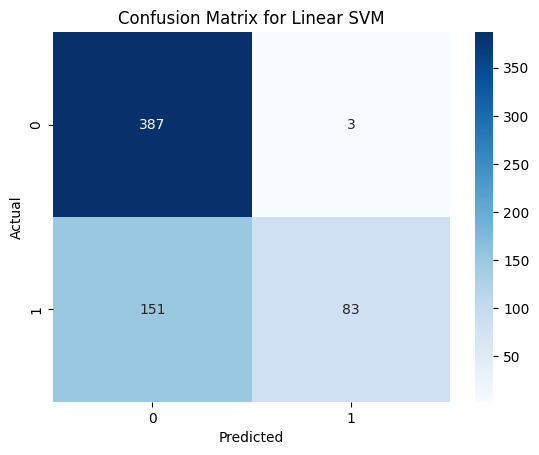

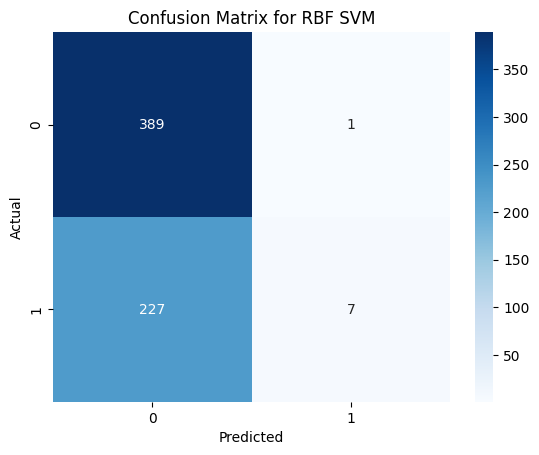

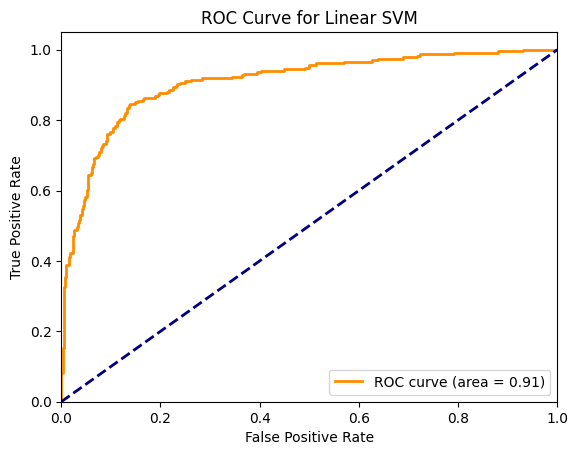

20/20 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step


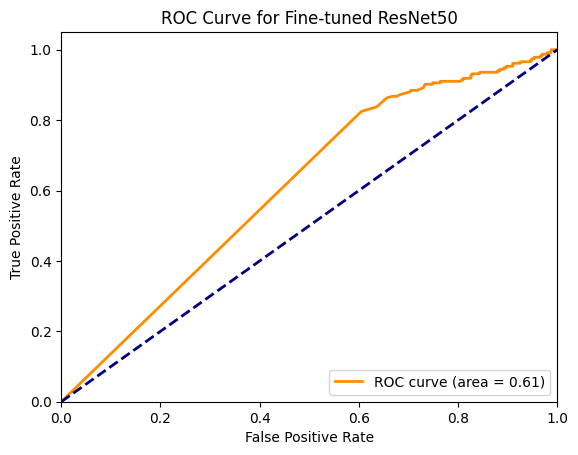

In [9]:
# (Step 7) Evaluation and Visualization

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

def plot_roc(y_true, y_pred, title):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

plot_confusion_matrix(y_test, y_pred, "Confusion Matrix for Linear SVM")
plot_confusion_matrix(y_test, y_pred_rbf, "Confusion Matrix for RBF SVM")

y_score = svm_linear.decision_function(test_features)
plot_roc(y_test, y_score, "ROC Curve for Linear SVM")

y_pred_proba = model.predict(x_test_rgb).ravel()
plot_roc(y_test, y_pred_proba, "ROC Curve for Fine-tuned ResNet50")
